In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.figure_factory as ff
from sqlalchemy import create_engine

In [ ]:
# Uncomment the next line and run this cell if mta_data.db is not in working directory
# %run get_mta.py "(1610|1611|1810|1811|2010|2011)"

### Upload and Read data
* Upload the database from the local file 'mta_data.db'
* Read the table 'mta_data' into Pandas using pd.read_sql()

In [2]:
# Query db from local files into a Pandas DataFrame
engine = create_engine("sqlite:///mta_data.db")

# Read the table into pandas
df = pd.read_sql(
    'SELECT * FROM mta_data', engine)

In [1]:
# Create png of table for presentation later
fig =  ff.create_table(df[df['STATION'].str.len() < 9].sample(5))
fig.update_layout(autosize=True, width = 900, height=125)
fig.write_image('images/table1.png')
fig.show()

NameError: name 'df' is not defined

### Find Duplicates
* Group by turnstile, date, and time to determine if there are duplicates
* Drop the duplicates

In [4]:
# Check for any duplicates on turnstiles
(df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'], as_index = False)
 .ENTRIES.count().sort_values('ENTRIES', ascending = False).head(10))

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
4557974,R417,R222,00-00-01,PARKCHESTER,10/16/2018,05:00:00,2
1687399,N120,R153,00-00-03,UTICA AV,10/12/2016,05:00:00,2
4387201,R315,R406,01-00-00,PROSPECT AV,10/04/2020,09:00:00,2
2064615,N310,R140,01-06-00,QUEENS PLAZA,10/06/2016,21:00:00,2
4387181,R315,R406,01-00-00,PROSPECT AV,10/03/2020,13:00:00,2
4560008,R417,R222,00-00-03,PARKCHESTER,10/07/2016,05:00:00,2
389407,B017,R262,00-00-02,BEVERLEY ROAD,10/08/2016,00:00:00,2
389409,B017,R262,00-00-02,BEVERLEY ROAD,10/08/2016,08:00:00,2
2204226,N332,R219,01-06-01,67 AV,10/27/2018,04:00:00,2
2203121,N332,R219,01-06-00,67 AV,10/27/2018,04:00:00,2


In [5]:
# Check why there is a duplicate by choosing a duplicated turnstile
df[((df['C/A'] == 'R417') & (df['UNIT'] == 'R222') & (df['SCP'] == '00-00-01') &
 (df['STATION'] == 'PARKCHESTER') & (df['DATE'] == '10/16/2018') & (df['TIME'] == '05:00:00'))]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
3066850,R417,R222,00-00-01,PARKCHESTER,6,IRT,10/16/2018,05:00:00,REGULAR,2649604,281638
3066851,R417,R222,00-00-01,PARKCHESTER,6,IRT,10/16/2018,05:00:00,RECOVR AUD,2649603,281638


In [6]:
# The duplicates are due to difference in DESC. Since the majority of the data has DESC value as 'REGULAR,
# we will drop any rows with a non-regular DESC (RECOVER AUD)
df = df[df['DESC'] == 'REGULAR']

### Sort to Split Later
* Sort by Date and Time and then group by turnstile and date to find last entry of each day
* Then split dataframe by year

In [7]:
# Change date and time columns for sorting
df['DATE'] = pd.to_datetime(df['DATE'])
df['TIME'] = pd.to_datetime(df['TIME'], format = '%H:%M:%S').dt.time

In [8]:
# Sort by DATE and TIME, then group to get values from end of day
df_daily_entries = (df.sort_values(['DATE', 'TIME'], ascending = (True, False))
            .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'], as_index = False)
            .ENTRIES.first())
df_daily_exits = (df.sort_values(['DATE', 'TIME'], ascending = (True, False))
            .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'], as_index = False)
            .EXITS.first())

In [9]:
# Looks good! Now we want to split it into 3 dataframes - by year
df_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,2016-09-24,5839333
1,A002,R051,02-00-00,59 ST,2016-09-25,5840123
2,A002,R051,02-00-00,59 ST,2016-09-26,5841712
3,A002,R051,02-00-00,59 ST,2016-09-27,5843424
4,A002,R051,02-00-00,59 ST,2016-09-28,5845070


In [10]:
# Split into 3 dataframes 
df2020 = df_daily_entries[df_daily_entries.DATE.dt.year == 2020].reset_index(drop = True)
df2018 = df_daily_entries[df_daily_entries.DATE.dt.year == 2018].reset_index(drop = True)
df2016 = df_daily_entries[df_daily_entries.DATE.dt.year == 2016].reset_index(drop = True)

# Put respective EXITS back
df2020['EXITS'] = df_daily_exits[df_daily_exits.DATE.dt.year == 2020].reset_index(drop = True)['EXITS']
df2018['EXITS'] = df_daily_exits[df_daily_exits.DATE.dt.year == 2018].reset_index(drop = True)['EXITS']
df2016['EXITS'] = df_daily_exits[df_daily_exits.DATE.dt.year == 2016].reset_index(drop = True)['EXITS']

In [11]:
df2016.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,2016-09-24,5839333,1979462
1,A002,R051,02-00-00,59 ST,2016-09-25,5840123,1979735
2,A002,R051,02-00-00,59 ST,2016-09-26,5841712,1980475
3,A002,R051,02-00-00,59 ST,2016-09-27,5843424,1981085
4,A002,R051,02-00-00,59 ST,2016-09-28,5845070,1981714


### Calculate Daily Entries/Exits
* Use `df.apply()` to calculate daily entries and exits
* We can sum these later to calculate daily traffic

In [12]:
def daily_traffic(row, max_counter = 250000):
    entries = row['ENTRIES'] - row['PREV_ENTRIES']
    if entries < 0:
        entries = -entries
    if entries > max_counter:
        entries = min(row['ENTRIES'], row['PREV_ENTRIES'])
    if entries > max_counter:
        entries = 0
    
    exits = row['EXITS'] - row['PREV_EXITS']
    if exits < 0:
        exits = -exits
    if exits > max_counter:
        exits = min(row['EXITS'], row['PREV_EXITS'])
    if exits > max_counter:
        exits = 0
    
    return pd.Series([entries, exits])


In [13]:
print(df2016[df2016['ENTRIES'] < df2016['ENTRIES'].shift(1)].shape,
      df2018[df2018['ENTRIES'] < df2018['ENTRIES'].shift(1)].shape,
      df2020[df2020['ENTRIES'] < df2020['ENTRIES'].shift(1)].shape)

(4551, 7) (4663, 7) (5277, 7)


In [14]:
df2016[['PREV_ENTRIES', 'PREV_EXITS']] = (df2016.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])
                                          ['ENTRIES', 'EXITS'].apply(lambda x: x.shift(1)))

df2018[['PREV_ENTRIES', 'PREV_EXITS']] = (df2018.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])
                                          ['ENTRIES', 'EXITS'].apply(lambda x: x.shift(1)))

df2020[['PREV_ENTRIES', 'PREV_EXITS']] = (df2020.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])
                                          ['ENTRIES', 'EXITS'].apply(lambda x: x.shift(1)))

In [15]:
df2016.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,2016-09-24,5839333,1979462,NaN,NaN
1,A002,R051,02-00-00,59 ST,2016-09-25,5840123,1979735,5839333.0,1979462.0
2,A002,R051,02-00-00,59 ST,2016-09-26,5841712,1980475,5840123.0,1979735.0
3,A002,R051,02-00-00,59 ST,2016-09-27,5843424,1981085,5841712.0,1980475.0
4,A002,R051,02-00-00,59 ST,2016-09-28,5845070,1981714,5843424.0,1981085.0


In [16]:
df2016[['DAILY_ENTRIES', 'DAILY_EXITS']] = df2016.apply(daily_traffic, axis = 1)

df2018[['DAILY_ENTRIES', 'DAILY_EXITS']] = df2018.apply(daily_traffic, axis = 1)

df2020[['DAILY_ENTRIES', 'DAILY_EXITS']] = df2020.apply(daily_traffic, axis = 1)

In [17]:
df2016.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
0,A002,R051,02-00-00,59 ST,2016-09-24,5839333,1979462,NaN,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,2016-09-25,5840123,1979735,5839333.0,1979462.0,790.0,273.0
2,A002,R051,02-00-00,59 ST,2016-09-26,5841712,1980475,5840123.0,1979735.0,1589.0,740.0
3,A002,R051,02-00-00,59 ST,2016-09-27,5843424,1981085,5841712.0,1980475.0,1712.0,610.0
4,A002,R051,02-00-00,59 ST,2016-09-28,5845070,1981714,5843424.0,1981085.0,1646.0,629.0


In [18]:
# We don't mind the null values here because they are only here for us to calculate the daily entries
# of future dates.
df2016.isna().sum()

C/A                 0
UNIT                0
SCP                 0
STATION             0
DATE                0
ENTRIES             0
EXITS               0
PREV_ENTRIES     4580
PREV_EXITS       4580
DAILY_ENTRIES    4580
DAILY_EXITS      4580
dtype: int64

In [19]:
# Drop columns we will no longer need
df2016.drop(columns=['ENTRIES', 'EXITS', 'PREV_ENTRIES', 'PREV_EXITS'], inplace = True)
df2018.drop(columns=['ENTRIES', 'EXITS', 'PREV_ENTRIES', 'PREV_EXITS'], inplace = True)
df2020.drop(columns=['ENTRIES', 'EXITS', 'PREV_ENTRIES', 'PREV_EXITS'], inplace = True)

### Calculate Station Totals
* Calculate the total entries per station
* Plot the top 10 stations for each year

In [20]:
# We group on the stations and date and sum the entries
station_daily2016 = df2016.groupby(['STATION', 'DATE'], as_index = False).DAILY_ENTRIES.sum()

station_daily2018 = df2018.groupby(['STATION', 'DATE'], as_index = False).DAILY_ENTRIES.sum()

station_daily2020 = df2020.groupby(['STATION', 'DATE'], as_index = False).DAILY_ENTRIES.sum()

In [21]:
# Now only group on the station for total entries in the time frame
station_total2016 = (station_daily2016.groupby('STATION', as_index = False).sum()
                     .sort_values('DAILY_ENTRIES', ascending = False).reset_index(drop = True))

station_total2018 = (station_daily2018.groupby('STATION', as_index = False).sum()
                     .sort_values('DAILY_ENTRIES', ascending = False).reset_index(drop = True))

station_total2020 = (station_daily2020.groupby('STATION', as_index = False).sum()
                     .sort_values('DAILY_ENTRIES', ascending = False).reset_index(drop = True))

[Text(0, 0.5, 'Daily Entries'), Text(0.5, 0, 'Station')]

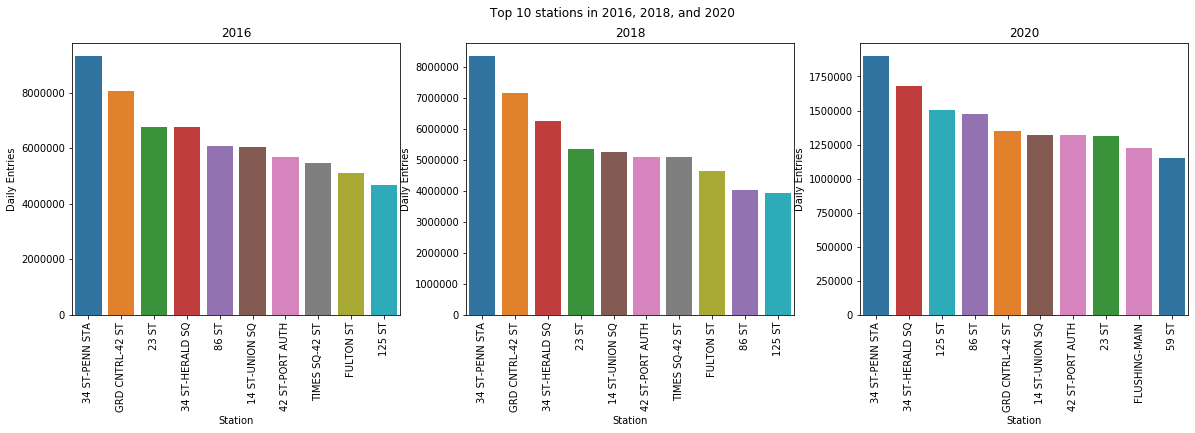

In [22]:
# Plot the top 10 stations of 2016, 2018, 2020
fig, axes = plt.subplots(1, 3, figsize = (20,5))
fig.suptitle('Top 10 stations in 2016, 2018, and 2020')

# Set color palette for plots
palette = {}
i = 0
for station in station_total2016.STATION:
    palette[station] = 'C'+str(i)
    i += 1

axes[0].set_title('2016')
b2016 = sns.barplot(ax = axes[0], x = station_total2016.STATION[0:10], y = station_total2016.DAILY_ENTRIES[0:10],
                   palette = palette)
b2016.set_xticklabels(b2016.get_xticklabels(),rotation = 90)
b2016.set(xlabel = 'Station', ylabel = 'Daily Entries')

axes[1].set_title('2018')
b2018 = sns.barplot(ax = axes[1], x = station_total2018.STATION[0:10], y = station_total2018.DAILY_ENTRIES[0:10],
                   palette = palette)
b2018.set_xticklabels(b2018.get_xticklabels(),rotation = 90)
b2018.set(xlabel = 'Station', ylabel = 'Daily Entries')

axes[2].set_title('2020')
b2020 = sns.barplot(ax = axes[2], x = station_total2020.STATION[0:10], y = station_total2020.DAILY_ENTRIES[0:10],
                   palette = palette)
b2020.set_xticklabels(b2020.get_xticklabels(),rotation = 90)
b2020.set(xlabel = 'Station', ylabel = 'Daily Entries')

### Current Findings
* The busiest stations are fairly consistent, regardless of year, but the number of entries during the pandemic are significantly lower, as expected.

* When comparing with pre-pandemic years, 2020 has some slight differences in the busiest stations. For example, 125 ST is the 3rd busiest station during 2020, but was the 10th busiest station in 2016 and 2018. 59 ST made it in the top 10 in 2020, but did not in 2016 or 2020.

In [23]:
# Export current dataframes to csv files for future use

df2016.to_csv('mta2016.csv', index = False)
df2018.to_csv('mta2018.csv', index = False)
df2020.to_csv('mta2020.csv', index = False)